<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/ClassificationTestes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# Importando as Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
import verde as vd
import random

### Algoritmos

In [4]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    target = 'Classe'
    X_columns = dataframe.columns[dataframe.columns != target]
    X = dataframe[X_columns]
    Y = dataframe[target]

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [153]:
def BlockSplit(dataframe, n_splits, seed, n_songs):

  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  test_list = []
  definitive_test_list = []


  for i in range(10):
    r = random.sample(range(i*songs_per_genre, (i+1)*songs_per_genre), n_test)
    for j in r:
      test_list.append(j)

  test_list.sort()
  for i in test_list:
    for j in range(n_block):
      definitive_test_list.append(round((i*n_block)+j))

  return definitive_test_list

In [161]:
def elbowKNN(dflist, n_neigh, seed, n_songs):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    neigh.fit(X.iloc[~df.index.isin(test)], Y.iloc[~df.index.isin(test)])
    Y_predict = neigh.predict(X.iloc[test])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [162]:
def elbowTree(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    clf.fit(X.iloc[~df.index.isin(test)], Y.iloc[~df.index.isin(test)])
    Y_predict = clf.predict(X.iloc[test])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [163]:
def elbowRF(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    rf.fit(X.iloc[~df.index.isin(test)], Y.iloc[~df.index.isin(test)])
    Y_predict = rf.predict(X.iloc[test])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

### Testes

In [9]:
#Ler CSVs
dflist = []

csvnames = ['3s_256.csv', '3s_512.csv','3s_1024.csv','3s_2048.csv','3s_4096.csv','3s8192.csv']

for i in csvnames:
  dir_path = os.path.join('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/csv/3s', i)
  dflist.append(pd.read_csv(dir_path, sep=',', encoding='utf-8'))


In [164]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

knnscores3 = []
knnscores5 = []
knnscores7 = []
dtscores = []
rfscores = []
# seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]
seeds = [14, 42, 60]


for seed in seeds:
  knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed, n_songs=500))
  knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed, n_songs=500))
  knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed, n_songs=500))

  dtscores.append(elbowTree(dflist, seed = seed, n_songs=500))
  rfscores.append(elbowRF(dflist, seed = seed, n_songs=500))

AttributeError: 'Flags' object has no attribute 'c_contiguous'

In [ ]:
# Coloca as listas de score em uma outra lista a cria listas com as médias e os sds.

scoreslist = []
scoresmeans = []
scoressds = []

scoreslist.append(np.array(knnscores3))
scoreslist.append(np.array(knnscores5))
scoreslist.append(np.array(knnscores7))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))

# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))

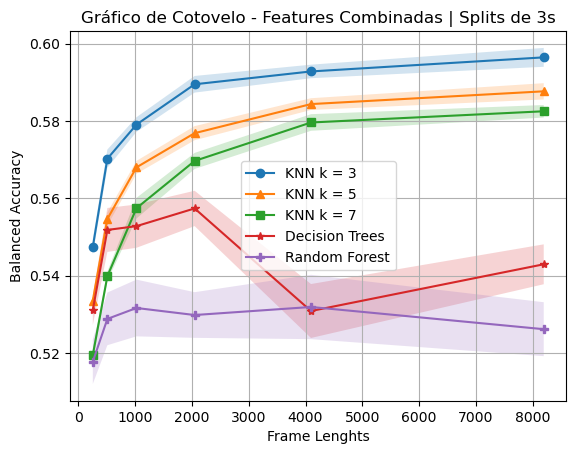

In [ ]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]
labels = ['KNN k = 3', 'KNN k = 5', 'KNN k = 7', 'Decision Trees', 'Random Forest']
markers = ['o', '^', 's', '*', 'P']

for i in range(len(scoresmeans)):
  plt.plot(frame_lenghts, scoresmeans[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeans[i] + scoressds[i], scoresmeans[i] - scoressds[i], alpha = 0.2)

plt.legend()
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo - Features Combinadas | Splits de 3s')

# Nome do arquivo pra salvar
plt.savefig('3s.pdf')
plt.show()

### Testezao

In [102]:
test = BlockKFoldCrossValidation(dataframe=dflist[3], n_splits=10, seed=40, n_songs=500)
test

[[29, 37, 33, 2, 15],
 [68, 92, 90, 63, 58],
 [148, 122, 117, 147, 128],
 [151, 183, 197, 158, 153],
 [241, 212, 239, 245, 229],
 [253, 261, 288, 270, 257],
 [316, 320, 309, 332, 343],
 [383, 356, 376, 353, 370],
 [446, 448, 421, 414, 447],
 [459, 469, 460, 483, 494]]

In [151]:
test = BlockKFoldCrossValidation(dataframe=dflist[3], n_splits=10, seed=40, n_songs=500)
test

df = dflist[3]
df.iloc[~df.index.isin(test)].head(30)

,0,1,2,3,4,5,6,7,8,9,...,1904,1905,1906,1907,1908,1909,1910,1911,1912,Classe
0,-18.703553,15.278344,3.237208,0.037474,-8.360602,4.101647,-7.124975,-9.215019,1.812679,3.556654,...,0.590413,0.272946,0.564359,-0.164848,-0.318813,0.234901,0.003641,0.040216,0.109863,blues
1,-14.658028,21.409093,4.474072,3.229463,-4.122167,-1.189049,3.460447,-5.423147,-0.214389,-2.463945,...,-0.339348,-0.062573,-0.099954,-0.138105,-0.118016,-0.234353,0.056324,-0.158040,0.047091,blues
2,-16.007186,18.493390,-8.402374,5.341473,-0.032693,-4.526731,-5.300347,-4.904725,2.536166,-4.534907,...,-0.695949,0.320114,0.002128,-0.337107,-0.271426,-0.261382,-0.399880,-0.330339,0.126231,blues
3,-17.664888,17.694944,6.243952,1.010191,-8.973858,1.312565,-1.536618,-11.289830,1.357270,1.781071,...,0.097408,-0.175964,-0.149499,0.329492,-0.284282,-0.171379,0.392095,0.018760,0.028458,blues
4,-15.479534,23.337921,5.234295,12.551086,-8.976488,4.711859,0.792269,-14.202758,-4.838247,-9.759548,...,-0.393427,0.019379,0.215775,-0.257794,0.275088,-0.136498,-0.161502,-0.371151,0.196985,blues
5,-13.005807,17.812657,-0.266499,0.634441,-1.658610,2.140194,-10.637150,-2.400286,1.348588,-1.997603,...,-0.253809,-0.439078,-0.214838,0.407376,-0.168091,-0.028520,-0.551979,-0.106024,-0.261847,blues
6,-8.687452,24.423032,5.852400,7.054708,0.023761,-3.014597,-0.210578,-9.342686,-0.823515,-1.564958,...,-0.446937,-0.342635,-0.163269,-0.013676,0.468760,0.154885,0.125672,-0.131879,-0.380993,blues
7,-16.717501,17.051522,5.332321,8.318127,-3.614035,1.041240,-6.706576,-11.497545,-0.075618,-3.811598,...,0.214052,0.291769,0.035622,-0.245367,0.110968,0.049635,-0.136900,-0.422276,-0.094450,blues
8,-16.724196,18.540501,10.216759,0.111560,-10.226328,0.771868,1.426320,-7.149722,-2.444075,2.662907,...,-0.164648,-0.138589,0.088085,0.027936,-0.243132,-0.284843,-0.358621,-0.424839,-0.263390,blues
9,-16.247654,20.753777,5.919710,11.396240,-0.023465,-8.251870,3.244982,-7.105283,10.969346,-0.981284,...,-0.321223,0.324746,-0.069214,-0.274876,0.408860,-0.123926,-0.413841,0.440957,0.638242,blues


In [145]:
train = range(10000)

train[test]

TypeError: range indices must be integers or slices, not list